In [1163]:
import psutil
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt
import scipy.signal as sg
import sklearn.preprocessing
import hmmlearn
import mne
import torch.nn as nn
import einops
import os
# import torch.nn.init as init
import torch.nn.functional as F
import time
from tqdm import tqdm
import math

import transitions
import importlib
importlib.reload(transitions)
from comet_ml import Experiment

In [1968]:
math.pi * 0.05**2 / 4

0.001963495408493621

In [1970]:
math.pi * 0.8**2 / 4

0.5026548245743669

In [1114]:
np.set_printoptions(precision=3)
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [1115]:
total_memory = psutil.virtual_memory().total
available_memory = psutil.virtual_memory().available
print(f"The available RAM memory is {available_memory / (1024**3):.2f} GB out of {total_memory / (1024**3):.2f} GB")

The available RAM memory is 12.57 GB out of 125.68 GB


# Read Data

In [939]:
fs = 4096
fsds = 1024
dataset = np.load('datasets/spmap_80-100hz.npz')
stimulus = dataset['stimulus']
ecogf = dataset['ecogf'][:,stimulus[1]:]
stimulus = stimulus[1:] - stimulus[1]
sound = dataset['sound'][stimulus[1]*4:]
ecogf = ecogf[:,:(ecogf.shape[1] // fsds) * fsds]
bad_channels = dataset['bad_channels']

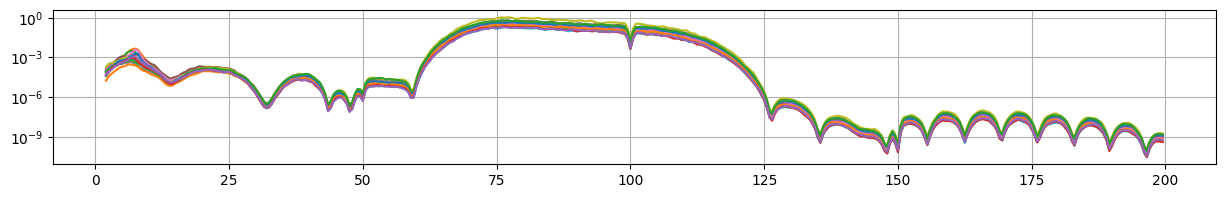

In [940]:
f, Pxx = sg.welch(ecogf, fsds, nperseg=2*fsds, noverlap=fsds, axis=-1)
fig, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.semilogy(f[4:400], Pxx[:, 4:400].T)
ax.grid()
plt.show()

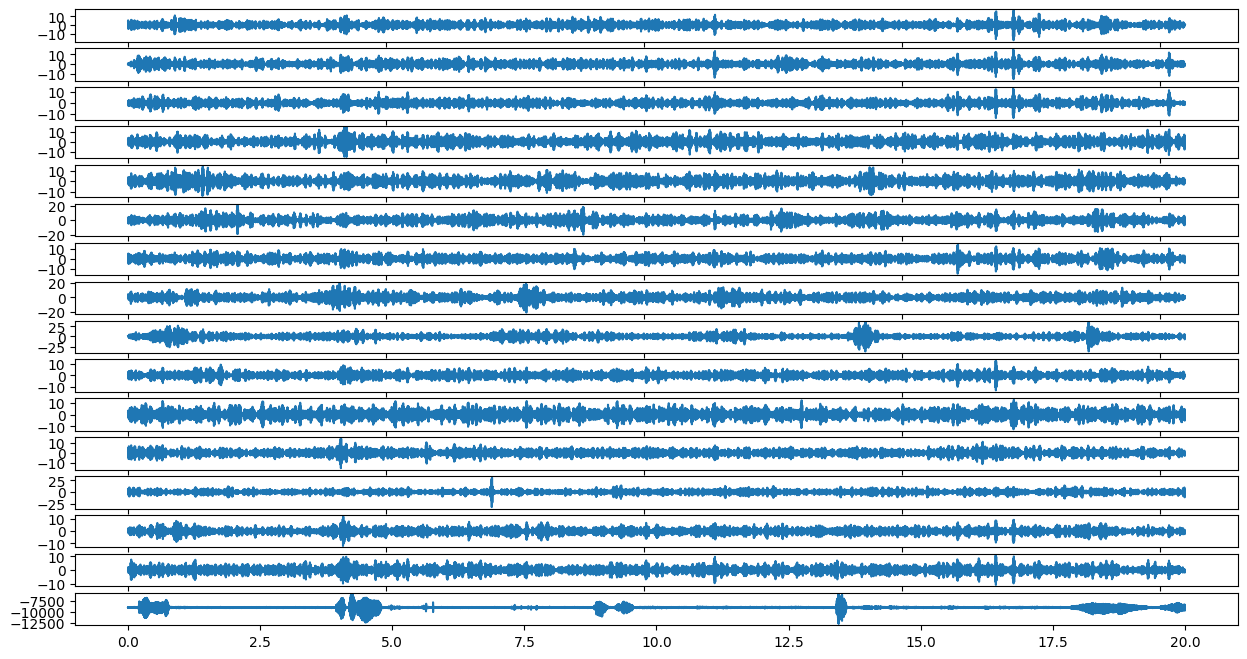

In [941]:
N = ecogf.shape[0]
a = stimulus[4]
s, t = a, a + 20*fsds
s_, t_ = a*4, a*4 + 20*fs

fig, ax = plt.subplots(N+1, 1, figsize=(15, 0.5*(N+1)))
for i in range(N):
    ax[i].plot(ecogf[i, s:t])
ax[N].plot(np.arange(sound[s_:t_].shape[0])/fs, sound[s_:t_])
plt.show()

# VAE

In [1681]:
class Rectifier(torch.nn.Module):
    def __init__(self, log_transform=False, logeps=1e-7):
        super(self.__class__,self).__init__()
        self.log_transform = log_transform
        self.eps = logeps
        
    def forward(self, s):
        s_abs = torch.abs(s)
        s_sign = torch.sign(s)
        if self.log_transform:
            s_abs = 2 * torch.log(s_abs + self.eps)
        return s_abs, s_sign
    
    def reverse(self, s_abs, s_sign):
        if self.log_transform:
            s_abs = torch.exp(s_abs / 2) - self.eps
        s = s_abs * s_sign
        return s

    
class Downsampler(torch.nn.Module):
    def __init__(self, in_fs, out_fs):
        super(self.__class__,self).__init__()
        self.downsample_coef = int(in_fs / out_fs)
    
    def forward(self, s_abs):
        s_abs_ = einops.rearrange(s_abs, 'b c (t d) -> b c d t', d=self.downsample_coef)
        a_mean = einops.reduce(s_abs_, 'b c d t -> b c t', 'mean')
        a_mean_ = einops.rearrange(a_mean, 'b c t -> b c 1 t')
        s_centered = s_abs_ - a_mean_
        a_cov = torch.einsum('bcdt,bCdt->bcCt', s_centered, s_centered) / (self.downsample_coef-1)
        return a_mean, a_cov

    
class Upsampler(torch.nn.Module):
    def __init__(self, in_fs, out_fs):
        super(self.__class__,self).__init__()
        self.upsample_coef = int(out_fs / in_fs)
        
    def forward(self, a_mean_tilde, a_cov_tilde=None, cov_propagation=False):
        s_abs = einops.repeat(a_mean_tilde, 'b c t -> b c (t d)', d=self.upsample_coef)
        s_cov = einops.repeat(a_cov_tilde, 'b c C t -> b c C (t d)', d=self.upsample_coef) if cov_propagation else None
        return s_abs, s_cov

    
class MovingAverage(torch.nn.Module):
    def __init__(self, order, n_sources, use_bias=True, bias_common=False):
        super(self.__class__,self).__init__()
        self.order = order
        self.n_sources = n_sources
        self.use_bias = use_bias
        
        # self.pad = nn.ConstantPad1d(padding=(order, 0), value=0)
        parameter_shape = (n_sources, n_sources, order)
        
        if self.use_bias and not bias_common:
            self.bias = nn.Parameter(torch.Tensor(n_sources))
            nn.init.constant_(self.bias, 0)
  
        if order > 0:
            self.moving_average = nn.Parameter(torch.Tensor(n_sources, n_sources, order))
            nn.init.kaiming_uniform_(self.moving_average, a=0.01)
            
            identity = torch.eye(n_sources).unsqueeze(-1).to(self.moving_average.device)
            self.register_buffer("identity", identity)

    def forward(self, a_mu, a_Sigma=None, cov_propagation=True, bias=None):
        x_Sigma = None

        if self.order > 0:
            batch_size = a_mu.shape[0]
            n_timestamps = a_mu.shape[-1]

            filtr = torch.cat([self.moving_average, self.identity], dim=-1)
            
            # x_mu_test = F.conv1d(a_mu_pad, filtr, bias=self.bias, stride=1, padding=0, dilation=1, groups=1)
            x_mu = torch.zeros((batch_size, self.n_sources, n_timestamps-self.order))
            for i in range(n_timestamps-self.order):
                x_mu[...,i] = torch.einsum('bCt,cCt->bc', a_mu[...,i:i+self.order+1], filtr)

            if cov_propagation:
                x_Sigma = torch.zeros((batch_size, self.n_sources, self.n_sources, n_timestamps-self.order))
                for i in range(n_timestamps-self.order):
                    x_Sigma[...,i] = torch.einsum('bCSt,cCt,sSt->bcs', a_Sigma[...,i:i+self.order+1], filtr, filtr)
                    
        elif self.order == 0:
            x_mu = a_mu
            if cov_propagation:
                x_Sigma = a_Sigma
                
        if self.use_bias:
            if bias is None:
                bias = self.bias
            bias = einops.rearrange(bias, 'c -> 1 c 1')
            x_mu = x_mu + bias
        return x_mu, x_Sigma
    
class SpatialFilter(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(self.__class__,self).__init__()

        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels))
        nn.init.kaiming_uniform_(self.weight, a=0.01)
        
    def forward(self, mean, cov=None, cov_propagation=False):
        mean = torch.einsum('bit, Oi -> bOt', mean, self.weight)
        cov = torch.einsum('biIt, oi, OI -> boOt', cov, self.weight, self.weight) if cov_propagation else None
        return mean, cov

    
class Encoder(torch.nn.Module):
    def __init__(
        self, n_channels, n_sources, log_transform, fsds, fsamp, 
        ma_order_encoder=0, ma_order_decoder=0, 
        ma_use_bias=True, ma_bias_common=False, ma_bias=None
    ):
        super(self.__class__,self).__init__()
        self.ds_coef = int(fsds / fsamp)
        self.ma_order = ma_order_encoder + ma_order_decoder
        
        self.spatial_filter = nn.Conv1d(n_channels, n_sources, kernel_size=1, bias=False)
        self.rectifier = Rectifier(log_transform)
        self.downsampler = Downsampler(in_fs=fsds, out_fs=fsamp)
        self.moving_average = MovingAverage(ma_order_encoder, n_sources, ma_use_bias, ma_bias_common)

    def forward(self, y, ma_bias=None):
        s = self.spatial_filter(y)
        s_abs, s_sign = self.rectifier(s)
        s_sign = s_sign[...,self.ma_order*self.ds_coef:]
        
        a_mean, a_cov = self.downsampler(s_abs)
        x_mean, x_cov = self.moving_average(a_mean, a_cov, cov_propagation=True, bias=ma_bias)
        
        s_abs = s_abs[...,self.ma_order*self.ds_coef:]
        return x_mean, x_cov, s_sign, s_abs, a_mean, a_cov
    

class Decoder(torch.nn.Module):
    def __init__(
        self, n_channels, n_sources, log_transform, fsds, fsamp, 
        use_temporal_smoother=False, temporal_smoother_kernel=51, ma_order_decoder=0, 
        ma_use_bias=True, ma_bias_common=False, ma_bias=None
    ):
        super(self.__class__,self).__init__()
        self.ds_coef = int(fsds / fsamp)

        self.moving_average = MovingAverage(ma_order_decoder, n_sources, ma_use_bias, ma_bias_common)
        self.upsampler = Upsampler(in_fs=fsamp, out_fs=fsds)
        self.rectifier = Rectifier(log_transform)
        self.use_temporal_smoother = use_temporal_smoother
        if self.use_temporal_smoother:
            self.temporal_smoother = torch.nn.Conv1d(
                n_sources, n_sources, kernel_size=temporal_smoother_kernel, bias=False,  groups=n_sources, padding='same')
        self.spatial_filter = SpatialFilter(n_sources, n_channels)


    def forward(self, x_mean_tilde, x_cov_tilde, s_sign, ma_bias, cov_propagation=False):
        a_mean_tilde, a_cov_tilde = self.moving_average(x_mean_tilde, x_cov_tilde, cov_propagation=cov_propagation, bias=ma_bias)
        y_mean_tilde, y_cov_tilde, s_abs_tilde = self.forward_amplitude(a_mean_tilde, a_cov_tilde, s_sign, cov_propagation=cov_propagation)
        return y_mean_tilde, y_cov_tilde, a_mean_tilde, a_cov_tilde, s_abs_tilde
    
    def forward_amplitude(self, a_mean_tilde, a_cov_tilde, s_sign, cov_propagation=False):
        s_abs_tilde, s_cov_tilde = self.upsampler(a_mean_tilde, a_cov_tilde, cov_propagation=cov_propagation)
        s_tilde = self.rectifier.reverse(s_abs_tilde, s_sign)
        if self.use_temporal_smoother:
            s_mean_tilde = self.temporal_smoother(s_tilde)
        y_mean_tilde, y_cov_tilde = self.spatial_filter(s_tilde, s_cov_tilde, cov_propagation=cov_propagation)
        return y_mean_tilde, y_cov_tilde, s_abs_tilde

In [1783]:
class VAE(torch.nn.Module):
    def __init__(
        self, 
        n_channels, 
        n_features, 
        log_transform, 
        fsds, 
        fsamp, 
        ma_order_encoder,
        ma_order_decoder,
        use_ma_bias,
        ma_bias_common, 
        use_temporal_smoother,
        temporal_smoother_kernel, 
        use_cov_scaler,
        random_seed,
    ):
        super(self.__class__,self).__init__()
        self.n_features = n_features
        self.ma_bias_common = ma_bias_common
        self.ds_coef = int(fsds / fsamp)
        self.ma_order_decoder = ma_order_decoder
        self.ma_order = ma_order_encoder + ma_order_decoder
        self.pad_encoder_decoder = nn.ReflectionPad1d(padding=(self.ma_order*self.ds_coef, 0))
        
        torch.manual_seed(random_seed)
        self.ma_bias = None
        self.ma_bias_common = ma_bias_common
        if self.ma_bias_common:
            self.ma_bias = nn.Parameter(torch.Tensor(self.n_features))
            nn.init.constant_(self.ma_bias, 0)
            
            
        self.config_encoder = {
            'n_channels':n_channels, 
            'n_features':n_features, 
            'log_transform':log_transform, 
            'fsds':fsds, 
            'fsamp':fsamp, 
            'ma_order_encoder':ma_order_encoder,
            'ma_order_decoder':ma_order_decoder, 
            'use_ma_bias':use_ma_bias, 
            'ma_bias_common':ma_bias_common,
        }
        self.encoder = Encoder(**self.config_encoder)
        
        self.config_decoder = {
            'n_channels':n_channels, 
            'n_features':n_features, 
            'log_transform':log_transform, 
            'fsds':fsds, 
            'fsamp':fsamp, 
            'use_temporal_smoother':use_temporal_smoother, 
            'temporal_smoother_kernel':temporal_smoother_kernel, 
            'ma_order_decoder':ma_order_decoder, 
            'use_ma_bias':use_ma_bias, 
            'ma_bias_common':ma_bias_common,
        }
        self.decoder = Decoder(**self.config_decoder)
        
        self.use_cov_scaler = use_cov_scaler
        if self.use_cov_scaler:
            self.cov_scaler = nn.Parameter(torch.Tensor(1))
            nn.init.constant_(self.cov_scaler, 1)
    
    def forward(self, y, cov_propagation=False):
        indices = [0]
        seq_length = int(y.shape[-1] / self.ds_coef)
        y_minibatch, y_mean_tilde, y_cov_tilde, a_mean, a_cov, x_mean, x_cov = self.forward_minibatch(
            y, indices, seq_length, cov_propagation=cov_propagation
        )
        y_minibatch = einops.rearrange(y_minibatch, '1 c t -> c t')
        y_mean_tilde = einops.rearrange(y_mean_tilde, '1 c t -> c t')
        if y_cov_tilde is not None:
            y_cov_tilde = einops.rearrange(y_cov_tilde, '1 c C t -> c C t')
        x_mean = einops.rearrange(x_mean, '1 c t -> c t')
        x_cov = einops.rearrange(x_cov, '1 c C t -> c C t')
        a_mean = einops.rearrange(a_mean, '1 c t -> c t')
        a_cov = einops.rearrange(a_cov, '1 c C t -> c C t')
        
        return y_minibatch, y_mean_tilde, y_cov_tilde, a_mean, a_cov, x_mean, x_cov
        
    
    def forward_minibatch(self, y, indices, seq_length, cov_propagation=False):
        y_pad = self.pad_encoder_decoder(y)
        y_minibatch_pad = [y_pad[:,index*self.ds_coef:(index+self.ma_order+seq_length)*self.ds_coef] for index in indices]
        y_minibatch_pad = torch.stack(y_minibatch_pad)
        y_minibatch = y_minibatch_pad[...,self.ma_order*self.ds_coef:]

        x_mean_pad, x_cov_pad, s_sign, s_abs, a_mean_pad, a_cov_pad = self.encoder(y_minibatch_pad, ma_bias=self.ma_bias)
        
        if self.use_cov_scaler:
            x_cov_pad = x_cov_pad * self.cov_scaler  
        
        y_mean_tilde, y_cov_tilde, a_mean_tilde, a_cov_tilde, s_abs_tilde = self.decoder(
            x_mean_pad, x_cov_pad, s_sign, ma_bias=-self.ma_bias, cov_propagation=cov_propagation,
        )

        x_mean, x_cov = x_mean_pad[...,self.ma_order_decoder:], x_cov_pad[...,self.ma_order_decoder:]
        a_mean, a_cov = a_mean_pad[...,self.ma_order_decoder:], a_cov_pad[...,self.ma_order_decoder:]

        return y_minibatch, y_mean_tilde, y_cov_tilde, a_mean, a_cov, x_mean, x_cov

    def reset(self, random_seed):
        torch.manual_seed(random_seed)
        if self.ma_bias_common:
            self.ma_bias = nn.Parameter(torch.Tensor(self.n_features))
            nn.init.constant_(self.ma_bias, 0)

        self.encoder = Encoder(**self.config_encoder)
        self.decoder = Decoder(**self.config_decoder)

        if self.use_cov_scaler:
            self.cov_scaler = nn.Parameter(torch.Tensor(1))
            nn.init.constant_(self.cov_scaler, 1)
        
        
    def dkl_loss(self, x_mean, x_cov, x_mean_prior, x_cov_prior):
        x_mean_diff = x_mean - x_mean_prior
        term1 = torch.einsum('bct,bcCt,bCt->bt', x_mean_diff, x_cov_prior, x_mean_diff)

        x_cov_rearranged = einops.rearrange(x_cov, 'b c C t -> b t c C')
        x_cov_prior_rearranged = einops.rearrange(x_cov_prior, 'b c C t -> b t c C')
        cholesky_factor = torch.linalg.cholesky(x_cov_prior_rearranged)
        x_covcov = torch.cholesky_solve(x_cov_rearranged, cholesky_factor)

        x_covcov_diag = torch.diagonal(x_covcov, dim1=2, dim2=3)
        term2 = torch.einsum('btc->bt', x_covcov_diag)

        term3_ = torch.linalg.slogdet(x_covcov)
        term3 = term3_.sign * term3_.logabsdet

        return 1/2 * (term1 + term2 - term3), term1, term2, term3

    def rec_loss(self, y, y_mean_tilde, y_cov_tilde, sigma2y, ds_coef, cov_propagation=False):
        y = einops.rearrange(y, 'b c (t d) -> b t d c', d=ds_coef)
        y_mean_tilde = einops.rearrange(y_mean_tilde, 'b c (t d) -> b t d c', d=ds_coef)
        y_diff = y_mean_tilde - y
        if not cov_propagation:
            y_diff_norm2 = torch.einsum('btdc,btdc->bt', y_diff, y_diff)
            rec_loss = y_diff_norm2 / (2*sigma2y)
        else:
            y_cov_tilde = einops.rearrange(y_cov_tilde, 'b c C (t d) -> b t d c C', d=ds_coef)
            noise_cov = sigma2y * einops.rearrange(torch.eye(y_cov_tilde.shape[-1], device=y_cov_tilde.device), 'c C -> 1 1 1 c C')
            y_cov_tilde = y_cov_tilde + noise_cov
            
            _, logabsdet = torch.linalg.slogdet(y_cov_tilde) # b t d
            logabsdet = torch.einsum('btd -> bt', logabsdet)

            cholesky_factor = torch.linalg.cholesky(y_cov_tilde)
            y_diff_ = einops.rearrange(y_mean_tilde, 'b t d c -> b t d c 1')
            y_diff_scaled_ = torch.cholesky_solve(y_diff_, cholesky_factor)
            y_diff_scaled = einops.rearrange(y_diff_scaled_, 'b t d c 1 -> b t d c')
            
            mahalanobis2 = torch.einsum('btdc, btdc -> bt', y_diff, y_diff_scaled)

            rec_loss = (mahalanobis2 + logabsdet) / 2
        return rec_loss

# Autoregression

In [1716]:
class Autoregression(torch.nn.Module):
    def __init__(
        self, 
        n_states,
        n_features,
        ar_order
    ):
        super(self.__class__,self).__init__()
        self.n_states = n_states
        self.n_features = n_features
        self.ar_order = ar_order
        
        self.pad = nn.ConstantPad1d(padding=(self.ar_order, 0), value=0)
        
        An = torch.zeros((self.n_states, self.ar_order + 2, self.n_features, self.n_features))
        An[:,0,:,:] = - einops.repeat(torch.eye(self.n_features), 'c C -> k c C', k=self.n_states)
        self.register_buffer("An", An)
        
        cov = einops.repeat(torch.eye(self.n_features), 'c C -> k c C', k=self.n_states)
        self.register_buffer("cov", cov)
        
        self.whitening_filters = torch.nn.ModuleList()
        for k in range(self.n_states):
            conv1d = torch.nn.Conv1d(self.n_features, self.n_features, kernel_size=self.ar_order+1)
            for param in conv1d.parameters():
                param.requires_grad = False
            self.whitening_filters.append(conv1d)
        self._update_filters()
        
    def _update_filters(self):
        An = self._get_ar_coef()
        mean = self._get_mean()
        for k in range(self.n_states):
            Akn = torch.flip(An[k], dims=(0,))
            Akn = einops.rearrange(Akn, 'n c C -> c C n')
            if self.ar_order > 0:
                self.whitening_filters[k].weight.data[:,:,:-1] = - Akn
            self.whitening_filters[k].weight.data[:,:,-1] = torch.eye(self.n_features, device=Akn.device)
            self.whitening_filters[k].bias.data = - mean[k]

        
    def _cholesky_inverse(self, matrix):
        cholesky_factor = torch.linalg.cholesky(matrix)
        matrix_inverse = torch.cholesky_inverse(cholesky_factor)
        return matrix_inverse

    def fit(self, x_mean, x_cov, gamma=None):
        n_samples = x_mean.shape[-1]
        pad = torch.nn.ConstantPad1d(padding=(self.ar_order, 0), value=0)
        x_mean_pad = self.pad(x_mean)
        x_cov_pad = self.pad(x_cov)
    
        if gamma is None:
            gamma = torch.ones((n_samples, self.n_states), device=x_mean.device) / self.n_states
        self.An[:,1:,:,:] = torch.clone(self._estimate_autoregression(x_mean, x_cov, gamma))
        self.cov = torch.clone(self._estimate_covariance(x_mean, x_cov, gamma))
        self._update_filters()
        
    def _signal_whitening(self, x_mean):
        es = torch.zeros(self.n_states, *x_mean.size(), device=x_mean.device)
        for k in range(self.n_states):
            e = self.whitening_filters[k](self.pad(x_mean))
            es[k] = e
        return es
    
    def emission_log_prob(self, x_mean):
        n_samples = x_mean.shape[-1]
        es = self._signal_whitening(x_mean)
        
        Dlog2pi = self.n_features * math.log(2*math.pi)
        
        _, logabsdet = torch.linalg.slogdet(self.cov)
        logabsdet = einops.rearrange(logabsdet, 'k -> k 1')

        cholesky_factor = torch.linalg.cholesky(self.cov)
        es_scaled = torch.cholesky_solve(es, cholesky_factor)
        mahalanobis = torch.einsum('kct, kct -> kt', es, es_scaled)
        
        log_prob = - 1/2 * (Dlog2pi + logabsdet + mahalanobis)
        return log_prob
        
    
    def get_posterior(self, x_mean, gamma):
        n_samples = x_mean.shape[-1]
        x_mean_pad = self.pad(x_mean)
        
        cov_hat_inv = self._cholesky_inverse(self.cov)
        gcov_hat_inv = torch.einsum('tk,kcC->tcC', gamma, cov_hat_inv)
        gcov_hat = self._cholesky_inverse(gcov_hat_inv)

        An_filt = torch.flip(self.An[:,1:], dims=(1,))

        gmean_hat = torch.zeros((n_samples, self.n_features), device=gcov_hat.device)
        for t in range(n_samples):
            x_mean_chunk = x_mean_pad[...,t:t+self.ar_order]
            x_mean_chunk = torch.cat([torch.ones((self.n_features,1), device=x_mean_chunk.device), x_mean_chunk], dim=-1)
            gmean_hat[t] = torch.einsum('cC, k, kCs, knsS, Sn -> c', gcov_hat[t], gamma[t], cov_hat_inv, An_filt, x_mean_chunk)
        return gmean_hat, gcov_hat
    
    def _get_ar_coef(self):
        return torch.clone(self.An[:,1:-1])
    def _get_mean(self):
        return torch.clone(torch.diagonal(self.An[:,-1], dim1=-2, dim2=-1))
    def _get_cov(self):
        return torch.clone(self.cov)
            
    def _estimate_autoregression(self, x_mean, x_cov, gamma):
        An_hat = torch.zeros((self.n_states, self.ar_order + 1, self.n_features, self.n_features), device=x_mean.device)
        x_meanT = einops.rearrange(x_mean, 'c t -> t c')
        x_covT = einops.rearrange(x_cov, 'c C t -> t c C')
        

        N, D = self.ar_order, self.n_features
        if N > 0:
            covn = [torch.cat((torch.zeros((n, self.n_features, self.n_features), device=x_mean.device), x_covT[:-n]), dim=0) for n in range(1, N+1)]
            covn = torch.stack(covn)
            gcov = torch.einsum('tk,ntcC->kncC', gamma, covn)
        
        for k in range(self.n_states):
            g = einops.rearrange(gamma[:,k], 't -> t 1')
            xn = [x_meanT] + [torch.cat((torch.zeros((n, self.n_features), device=x_mean.device), x_meanT[:-n]), dim=0) for n in range(1, N+1)]
            xng = [g*xn_ for xn_ in xn]

            B = torch.sum(xng[0], dim=0, keepdims=True)
            if N > 0:
                B = torch.cat([(xn[n].T @ xng[0]) for n in range(1, N+1)] + [B], dim=0)

            M = torch.zeros((N*D+1, N*D+1), device=x_mean.device)
            for i in range(1, N+1):
                x_ = torch.sum(xng[i], dim=0)
                M[-1,(i-1)*D:i*D] = x_
                M[(i-1)*D:i*D,-1] = x_
            M[-1,-1] = torch.sum(g)

            for i in range(1, N+1):
                for j in range(1, N+1):
                    if j > i: 
                        xgx = xn[i].T @ xng[j]
                        M[D*(i-1):D*i, D*(j-1):D*j] = xgx
                        M[D*(j-1):D*j, D*(i-1):D*i] = xgx.T
                    elif j == i:
                        xgx = xn[i].T @ xng[j]
                        M[D*(i-1):D*i, D*(j-1):D*j] = xgx + gcov[k,i-1]

            cholesky_factor = torch.linalg.cholesky(M)
            A = torch.cholesky_solve(B, cholesky_factor)

            if N > 0:
                An_hat[k,:-1] = einops.rearrange(A[:-1], '(N D) d -> N d D', N=N)
            An_hat[k,-1] = torch.diag(A[-1])
        return An_hat
    
    def _estimate_covariance(self, x_mean, x_cov, gamma):
        n_samples = x_mean.shape[-1]
        x_mean_pad = self.pad(x_mean)
        x_cov_pad = self.pad(x_cov)

        An_mean = torch.flip(self.An, dims=(1,))
        An_cov = torch.flip(self.An[:,:-1], dims=(1,))

        cov = torch.zeros((self.n_states, self.n_features, self.n_features, n_samples), device=x_mean_pad.device)
        for t in range(n_samples):
            x_mean_chunk = x_mean_pad[...,t:t+self.ar_order+1]
            x_mean_chunk = torch.cat([torch.ones((self.n_features,1), device=x_mean_chunk.device), x_mean_chunk], dim=-1)
            x_cov_chunk = x_cov_pad[...,t:t+self.ar_order+1]
            left = torch.einsum('kncC, CSn, knsS -> kcs', An_cov, x_cov_chunk, An_cov)
            right = torch.einsum('kncC, Cn, Sm, kmsS -> kcs', An_mean, x_mean_chunk, x_mean_chunk, An_mean)
            cov[...,t] = left + right

        gamma_sum = einops.rearrange(torch.einsum('tk->k', gamma), 'k -> k 1 1')
        cov_hat = torch.einsum('tk,kcCt->kcC', gamma, cov) / gamma_sum
        return cov_hat
    
    def reset(self):
        self.An = torch.zeros((self.n_states, self.ar_order + 2, self.n_features, self.n_features))
        self.An[:,0,:,:] = - einops.repeat(torch.eye(self.n_features), 'c C -> k c C', k=self.n_states)
        self.cov = einops.repeat(torch.eye(self.n_features), 'c C -> k c C', k=self.n_states)
        self._update_filters()

# HMM

In [1717]:
import importlib
import transitions
importlib.reload(transitions)

class HMM(torch.nn.Module):
    def __init__(
        self,
        n_states,
        init_state_type,
        transition_matrix_type,
        transition_type,
        diagonal_coef,
        first_coef,
        ergodicity_coef,
        temperature,
        random_seed,
    ):
        super(self.__class__,self).__init__()
        self.n_states = n_states
        self.temperature = temperature
        
        init_state_helper = transitions.InitState(
            n_states, 
            init_state_type, 
            random_seed
        )
        init_state = init_state_helper.get_init_state()
        self.register_buffer("init_state", init_state)

        transition_helper = transitions.TransitionMatrix(
            n_states, 
            transition_matrix_type, 
            transition_type, 
            diagonal_coef, 
            first_coef, 
            ergodicity_coef, 
            random_seed,
        )
        transition_matrix = transition_helper.get_transition_matrix()
        self.register_buffer("transition_matrix", transition_matrix)
        
        
    def forward(self, x, log_gamma):
        # features = self.feature_extractor(x)
        # loss = self.autoregression(features, torch.exp(log_gamma))
        return None

    def alpha_calculation(self, emissions): 
        T_max = emissions.shape[0]
        log_alpha = torch.zeros((T_max, self.n_states), device=emissions.device)
        for t in range(T_max):
            if t == 0:
                transition = torch.log(self.init_state)
            else:
                transition = torch.log(self.transition_matrix) + einops.rearrange(log_alpha[t-1,:], 'i -> i 1')
                transition = torch.logsumexp(transition, dim=0)
            log_alpha[t] = emissions[t] + transition
        return log_alpha
    
    def beta_calculation(self, emissions):
        T_max = emissions.shape[0]
        log_beta = torch.zeros((T_max, self.n_states), device=emissions.device)
        for t in list(range(T_max-1))[::-1]:
            log_transition_matrix = torch.log(self.transition_matrix)
            emission = einops.rearrange(emissions[t+1], 'j -> 1 j')
            log_beta_ = einops.rearrange(log_beta[t+1], 'j -> 1 j')
            log_beta_zj = log_transition_matrix + emission + log_beta_
            log_beta[t] = torch.logsumexp(log_beta_zj, dim=1)
        return log_beta
    
    def gamma_calculation(self, log_alpha, log_beta, mask):
        log_gamma_unnormalized = log_alpha + log_beta
        log_gamma_normalization = torch.logsumexp(log_gamma_unnormalized, dim=1, keepdim=True)
        log_gamma = log_gamma_unnormalized - log_gamma_normalization
        return log_gamma, log_gamma_normalization
    
    def xi_calculation(self, log_alpha, log_beta, emissions, mask=None):
        T_max = emissions.shape[0]
        if mask is None: mask = -1 * torch.ones(T_max, device=emissions.device)

        log_xi = torch.zeros((T_max-1, self.n_states, self.n_states), device=emissions.device)
        
        left = einops.rearrange(log_alpha[:-1], 'L i -> L i 1')
        right = einops.rearrange(emissions[1:], 'L j -> L 1 j')
        right += einops.rearrange(log_beta[1:], 'L j -> L 1 j')
        middle = einops.repeat(torch.log(self.transition_matrix), 'i j -> L i j', L=T_max-1).clone()

        log_xi = left + middle + right

        marginal_likelihood = torch.logsumexp(log_xi, dim=(1, 2), keepdim=True)
        log_xi = log_xi - marginal_likelihood
        return log_xi
    
    
    def fit(self, emissions, mask=None):
        T_max = emissions.shape[0]
        log_alpha = self.alpha_calculation(emissions)
        log_beta = self.beta_calculation(emissions)
        log_gamma, _ = self.gamma_calculation(log_alpha, log_beta, mask)
        log_xi = self.xi_calculation(log_alpha, log_beta, emissions, mask)
        
        # if self.temperature != 1:
        #     log_gamma = log_gamma * self.temperature
        #     log_gamma = log_gamma - torch.logsumexp(log_gamma, dim=1, keepdim=True)
        #     log_xi = log_xi * self.temperature
        #     log_xi = log_xi - torch.logsumexp(log_xi, dim=(1, 2), keepdim=True)
        
        log_init_state = log_gamma[0]
        log_transition_matrix = torch.logsumexp(log_xi, dim=0) - torch.logsumexp(log_gamma[:-1], dim=0).unsqueeze(-1)

        init_state = torch.exp(log_init_state)**self.temperature
        self.init_state = init_state / torch.sum(init_state)
        transition_matrix = torch.exp(log_transition_matrix)**self.temperature
        self.transition_matrix = transition_matrix / torch.sum(transition_matrix, dim=1, keepdims=True)

        log_prob = log_alpha.logsumexp(dim=1)[-1]
        gamma = torch.exp(log_gamma)
        return log_prob, gamma
    
        
    def predict(self, emissions, mask=None):
        T_max = emissions.shape[0]
        log_delta = torch.zeros((T_max, self.n_states), device=emissions.device)
        psi = torch.zeros((T_max, self.n_states), device=emissions.device)
        path = torch.zeros(T_max, dtype=torch.long, device=emissions.device)

        for t in range(T_max):
            emission = emissions[t]
            
            if t == 0:
                transition, backtrack = torch.log(self.init_state), 0
            else:
                transition_ = torch.log(self.transition_matrix) + einops.rearrange(log_delta[t-1,:], 'i -> i 1')
                transition, backtrack = torch.max(transition_, dim=0)[0], torch.argmax(transition_, dim=0)
            log_delta[t] = emission + transition
            psi[t] = backtrack

        path[-1] = torch.argmax(log_delta[-1], dim=0)
        for t in list(range(T_max-1))[::-1]:
            path[t] = psi[t+1, path[t+1]]
        return path
    
    def reset(
        self,
        n_states,
        init_state_type,
        transition_matrix_type,
        transition_type,
        diagonal_coef,
        first_coef,
        ergodicity_coef,
        temperature,
        random_seed,
    ):
        self.n_states = n_states
        self.temperature = temperature
        
        init_state_helper = transitions.InitState(
            n_states, 
            init_state_type, 
            random_seed
        )
        self.init_state = init_state_helper.get_init_state()

        transition_helper = transitions.TransitionMatrix(
            n_states, 
            transition_matrix_type, 
            transition_type, 
            diagonal_coef, 
            first_coef, 
            ergodicity_coef, 
            random_seed,
        )
        self.transition_matrix = transition_helper.get_transition_matrix()

# VAEARHMM

In [1894]:
class VAEARHMM(torch.nn.Module):
    def __init__(
        self,
        config,
        experiment=None, 
    ):
        super(self.__class__,self).__init__()
        self.experiment = experiment
        
        
        self.config_hmm = {
            'n_states'=config.n_states,
            'init_state_type'=config.init_state_type,
            'transition_matrix_type'=config.transition_matrix_type,
            'transition_type'=config.transition_type,
            'diagonal_coef'=config.diagonal_coef,
            'first_coef'=config.first_coef,
            'ergodicity_coef'=config.ergodicity_coef,
            'temperature'=config.temperature,
            'random_seed'=config.random_seed,
        }
        self.hmm = HMM(**self.config_hmm)
        
        self.ar = Autoregression(
            # device=config.device, 
            n_states=config.n_states,
            n_features=config.n_features,
            ar_order=config.ar_order
        )
        self.vae = VAE(
            # device=config.device, 
            n_channels=config.n_channels, 
            n_features=config.n_features, 
            log_transform=config.log_transform, 
            fsds=config.fsds, 
            fsamp=config.fsamp, 
            ma_order_encoder=config.ma_order_encoder, 
            ma_order_decoder=config.ma_order_decoder, 
            use_ma_bias=config.use_ma_bias, 
            ma_bias_common=config.ma_bias_common, 
            use_temporal_smoother=config.use_temporal_smoother, 
            temporal_smoother_kernel=config.temporal_smoother_kernel, 
            use_cov_scaler=config.use_cov_scaler, 
        )
        
        
    def forward(self, x):
        return None
        
    def fit_vae(self, y, x_mean_prior, x_cov_prior, config, epoch_offset=0, pretain_epoch=None, verbose=False):
        x_length = int(y.shape[-1] / config.ds_coef)
        optimizer = torch.optim.AdamW(self.vae.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        self.vae.train()
        n_epochs = config.n_epochs if pretain_epoch is None else pretain_epoch
        
        iterator = range(1 + epoch_offset, n_epochs+1 + epoch_offset)
        if verbose:
            iterator = tqdm(iterator)
        for epoch in iterator:
            optimizer.zero_grad()
            indices = np.random.choice(np.arange(x_length - config.seq_length + 1), size=config.batch_size, replace=False)
            
            x_mean_prior_minibatch = [x_mean_prior[...,index:(index+config.seq_length)] for index in indices]
            x_mean_prior_minibatch = torch.stack(x_mean_prior_minibatch)
            
            x_cov_prior_minibatch = [x_cov_prior[...,index:(index+config.seq_length)] for index in indices]
            x_cov_prior_minibatch = torch.stack(x_cov_prior_minibatch)

            y_minibatch, y_mean_tilde, y_cov_tilde, _, _, x_mean_minibatch, x_cov_minibatch = self.vae.forward_minibatch(
                y, indices, config.seq_length, cov_propagation=config.cov_propagation
            )
            
            rec = self.vae.rec_loss(y_minibatch, y_mean_tilde, y_cov_tilde, config.sigma2y, config.ds_coef, cov_propagation=config.cov_propagation)
            dkl, _, _, _ = self.vae.dkl_loss(x_mean_minibatch, x_cov_minibatch, x_mean_prior_minibatch, x_cov_prior_minibatch)
            
            rec = torch.mean(rec) / config.ds_coef
            dkl = torch.mean(dkl)
        
            loss = rec + dkl
            loss.backward()
            optimizer.step()
    
            if self.experiment is not None:
                if epoch % 10 == 0:
                    self.experiment.log_metric("loss", (rec + dkl).detach().cpu().numpy().item(), step=epoch)
                    self.experiment.log_metric("rec", rec.detach().cpu().numpy().item(), step=epoch)
                    self.experiment.log_metric("dkl", dkl.detach().cpu().numpy().item(), step=epoch)
        self.vae.eval()
        
    def fit(self, y, config, mask=None):
        n_samples = int(y.shape[-1] / config.ds_coef)
        # pretrain vae
        x_mean_prior = torch.zeros((config.n_features, n_samples), device=y.device)
        x_cov_prior = einops.repeat(torch.eye(config.n_features, device=y.device), 'c C -> c C t', t=n_samples)
        self.fit_vae(y, x_mean_prior, x_cov_prior, config, pretain_epoch=config.pretain_epoch, verbose=True)

        for iteration in tqdm(range(config.n_iterations)):
            epoch_offset = iteration*config.n_epochs + config.pretain_epoch
            for i in range(10):
                # forward
                y_minibatch, y_tilde, _, x_mean, x_cov = self.vae(y)
                y_minibatch, y_tilde, x_mean, x_cov = y_minibatch.detach(), y_tilde.detach(), x_mean.detach(), x_cov.detach()

                emissions = self.ar.emission_log_prob(x_mean)
                # backward
                emissions = einops.rearrange(emissions, 'k t -> t k')
                log_prob, gamma = self.hmm.fit(emissions)
                if self.experiment is not None:
                    self.experiment.log_metric("prob_loss", - log_prob.detach().cpu().numpy().item(), step=i + iteration*10)
                self.ar.fit(x_mean, x_cov, gamma)
            x_mean_hat, x_cov_hat = self.ar.get_posterior(x_mean, gamma)
            
            x_mean_hat = einops.rearrange(x_mean_hat, 't c -> c t')
            x_cov_hat = einops.rearrange(x_cov_hat, 't c C -> c C t')
            
            self.fit_vae(y, x_mean_hat, x_cov_hat, config, epoch_offset=epoch_offset)
            
    def fit_simple(self, y, config, mask=None):
        n_samples = int(y.shape[-1] / config.ds_coef)
        # pretrain vae
        x_mean_prior = torch.zeros((config.n_features, n_samples), device=y.device)
        x_cov_prior = einops.repeat(torch.eye(config.n_features, device=y.device), 'c C -> c C t', t=n_samples)
        self.fit_vae(y, x_mean_prior, x_cov_prior, config, pretain_epoch=config.pretain_epoch, verbose=True)
        
        _, _, _, _, _, x_mean, x_cov = self.vae(y)
        x_mean, x_cov = x_mean.detach(), x_cov.detach()
        # forward

        for i in tqdm(range(config.n_iterations)):
            x_cov = torch.zeros(x_cov.shape, device=x_cov.device)
            emissions = self.ar.emission_log_prob(x_mean)
            # backward
            emissions = einops.rearrange(emissions, 'k t -> t k')
            log_prob, gamma = self.hmm.fit(emissions)
            if self.experiment is not None:
                self.experiment.log_metric("prob_loss", - log_prob.detach().cpu().numpy().item(), step=(i+1)*100)
            self.ar.fit(x_mean, x_cov, gamma)

            
    def prefict(self, y):
        y_minibatch, y_mean_tilde, y_cov_tilde, _, _, x_mean, x_cov = self.vae(y, cov_propagation=True)
        emissions = self.ar.emission_log_prob(x_mean)
        emissions = einops.rearrange(emissions, 'k t -> t k')
        path = self.hmm.predict(emissions)
        return y_minibatch, y_mean_tilde, y_cov_tilde, x_mean, x_cov, path

In [1895]:
class Config:
    def __init__(self):
        pass
        
config = Config()
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.random_seed = 42

config.n_states = 2
config.n_features = 3
config.n_channels = 15


# hmm params
config.init_state_type = 'first'
config.transition_matrix_type = 'random'
config.transition_type = 'full'
config.diagonal_coef = 0
config.first_coef = 10
config.ergodicity_coef = 0
config.temperature = 1

# ar params
config.ar_order = 0

# vae params
config.log_transform = False
config.fsds = 1024
config.fsamp = 16
config.ds_coef = int(config.fsds/config.fsamp)
config.ma_order_encoder = 0
config.ma_order_decoder = 0
config.use_ma_bias = False
config.ma_bias_common = True
config.use_temporal_smoother = False
config.temporal_smoother_kernel = 75
config.sigma2y = 10
config.use_cov_scaler = False
config.cov_propagation = False

config.pretain_epoch = 500
config.batch_size = 100
config.seq_length = 50
config.n_iterations = 10
config.n_epochs = 500
config.lr = 3e-4
config.weight_decay = 1e-4

# Go Nuts

In [1651]:
experiment = None
experiment = Experiment(
    api_key="h1D6l9T1S26xlDYKakWxGBudo",
    project_name="vae",
    workspace="amvosk",
    auto_output_logging=False,
)
experiment.log_code()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch, sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/user/common/amvosk/Projects/Speech Mapping Advanced' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/amvosk/vae/524924d2537749fe94ed33223e5b874e

COMET WARNING: unable to find caller source code in a jupyter notebook; ignoring


In [1652]:
vaearhmm = VAEARHMM(
    config,
    experiment,
).to(config.device)
y = torch.tensor(ecogf, dtype=torch.float32).to(config.device)

In [1653]:
print(vaearhmm.hmm.init_state)
print(vaearhmm.hmm.transition_matrix)
print(vaearhmm.ar._get_mean())
print(vaearhmm.ar._get_cov())
print(vaearhmm.ar._get_ar_coef())
if config.use_ma_bias:
    print(vaearhmm.vae.ma_bias)
if config.use_cov_scaler:
    print(vaearhmm.vae.cov_scaler)

tensor([1.0000e+00, 1.0000e-07], device='cuda:0')
tensor([[0.9224, 0.0776],
        [0.2853, 0.7147]], device='cuda:0')
tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')
tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]], device='cuda:0')
tensor([], device='cuda:0', size=(2, 0, 3, 3))


In [1654]:
try:
    vaearhmm.fit(y, config)
finally:
    if experiment is not None:
        experiment.end()

100%|██████████| 10/10 [03:37<00:00, 21.73s/it]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/amvosk/vae/524924d2537749fe94ed33223e5b874e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     dkl [550]       : (1.9942288398742676, 4.658170223236084)
COMET INFO:     loss [550]      : (6.82823371887207, 16.154048919677734)
COMET INFO:     prob_loss [100] : (4626.513671875, 12596.828125)
COMET INFO:     rec [550]       : (4.66092586517334, 11.495878219604492)
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 

In [1638]:
y_minibatch, y_tilde, x_mean, x_cov, path = vaearhmm.prefict(y)

In [1639]:
x_cov[...,-100]

tensor([[ 0.7727, -0.1796,  0.1776],
        [-0.1796,  0.5189,  0.2122],
        [ 0.1776,  0.2122,  0.6636]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [1640]:
print(vaearhmm.hmm.init_state)
print(vaearhmm.hmm.transition_matrix)
print(vaearhmm.ar._get_mean())
print(vaearhmm.ar._get_cov())
print(vaearhmm.ar._get_ar_coef())
if config.use_ma_bias:
    print(vaearhmm.vae.ma_bias)
if config.use_cov_scaler:
    print(vaearhmm.vae.cov_scaler)

tensor([1.0000e+00, 8.8503e-08], device='cuda:0')
tensor([[0.9290, 0.0710],
        [0.3052, 0.6948]], device='cuda:0')
tensor([[1.2759, 1.2963, 1.2933],
        [1.2760, 1.2966, 1.2938]], device='cuda:0')
tensor([[[0.9793, 0.0534, 0.0480],
         [0.0534, 0.9950, 0.0398],
         [0.0480, 0.0398, 0.9935]],

        [[0.9796, 0.0534, 0.0481],
         [0.0534, 0.9957, 0.0398],
         [0.0481, 0.0398, 0.9942]]], device='cuda:0')
tensor([], device='cuda:0', size=(2, 0, 3, 3))


In [1641]:
total_memory = psutil.virtual_memory().total
available_memory = psutil.virtual_memory().available
print(f"The available RAM memory is {available_memory / (1024**3):.2f} GB out of {total_memory / (1024**3):.2f} GB")

The available RAM memory is 21.22 GB out of 125.68 GB


In [1642]:
index = 1
a_ = stimulus[index]*4
a = stimulus[index]
b = a // config.ds_coef
s, t = a, a + 20*fsds
s_, t_ = a_, a_ + 20*fs

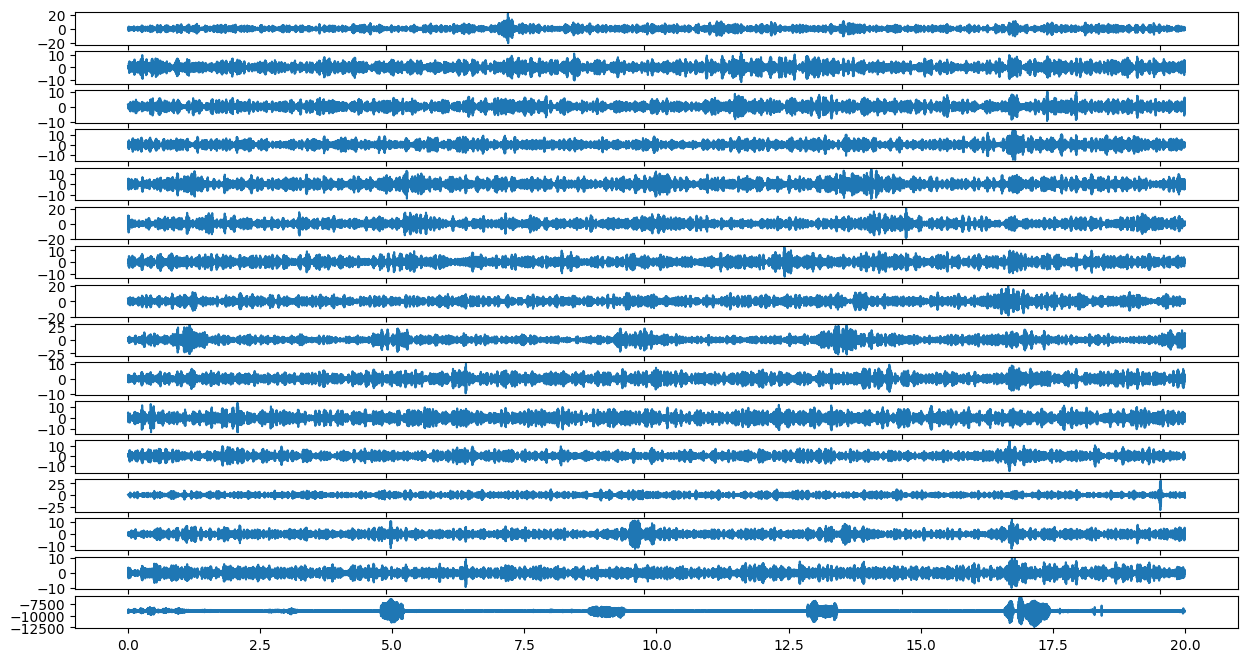

In [1643]:
N = ecogf.shape[0]
fig, ax = plt.subplots(N+1, 1, figsize=(15, 0.5*(N+1)))
for i in range(N):
    ax[i].plot(ecogf[i, s:t])
ax[N].plot(np.arange(sound[s_:t_].shape[0])/fs, sound[s_:t_])
plt.show()

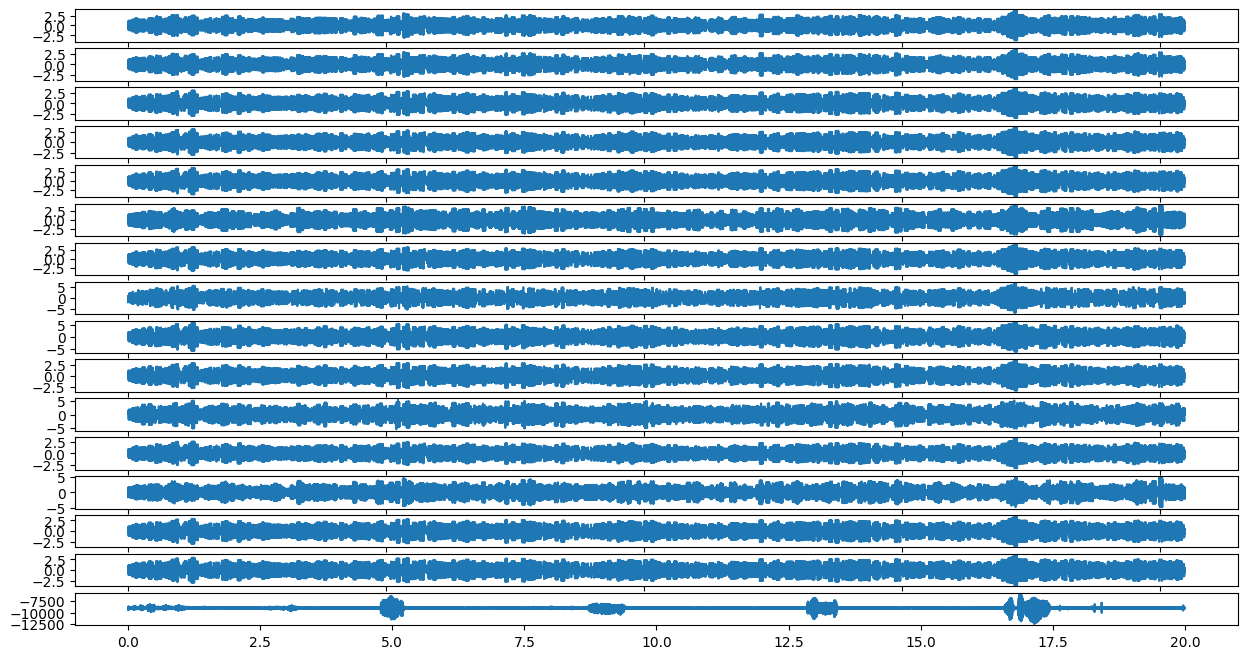

In [1644]:
y_hat = y_tilde.detach().cpu().numpy()

N = y_hat.shape[0]
s, t = a, a + 20*fsds
s_, t_ = a_, a_ + 20*fs

fig, ax = plt.subplots(N+1, 1, figsize=(15, 0.5*(N+1)))
for i in range(N):
    ax[i].plot(y_hat[i, s:t])
ax[N].plot(np.arange(sound[s_:t_].shape[0])/fs, sound[s_:t_])
plt.show()

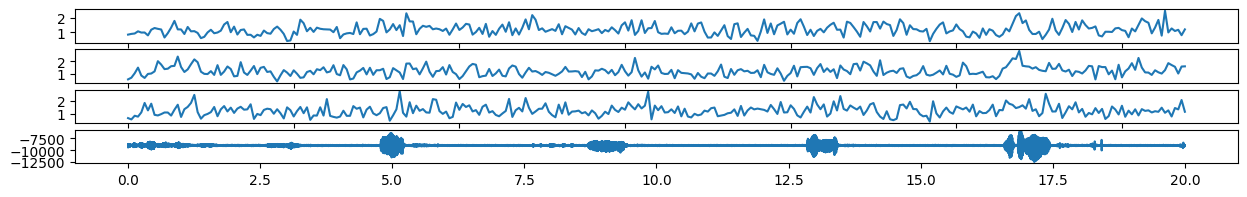

In [1645]:
x_hat = x_mean.detach().cpu().numpy()

N = x_hat.shape[0]
s, t = b, b + 20*config.fsamp
s_, t_ = a_, a_ + 20*fs

fig, ax = plt.subplots(N+1, 1, figsize=(15, 0.5*(N+1)))
for i in range(N):
    ax[i].plot(x_hat[i, s:t])
ax[N].plot(np.arange(sound[s_:t_].shape[0])/fs, sound[s_:t_])
plt.show()

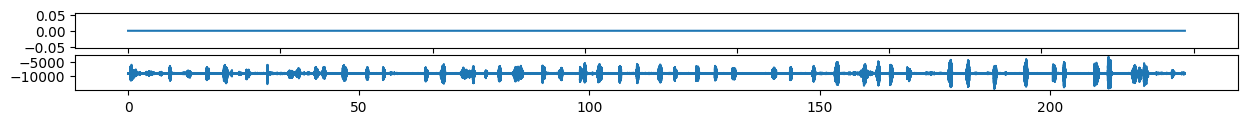

In [1646]:
z_hat = path.detach().cpu().numpy()

s, t = b, b + 20*config.fsamp
s_, t_ = a_, a_ + 20*fs

fig, ax = plt.subplots(2, 1, figsize=(15, 1))
# ax[0].plot(z_hat[s:t])
ax[0].plot(z_hat)
# ax[1].plot(np.arange(sound[s_:t_].shape[0])/fs, sound[s_:t_])
ax[1].plot(np.arange(sound.shape[0])/fs, sound)
plt.show()

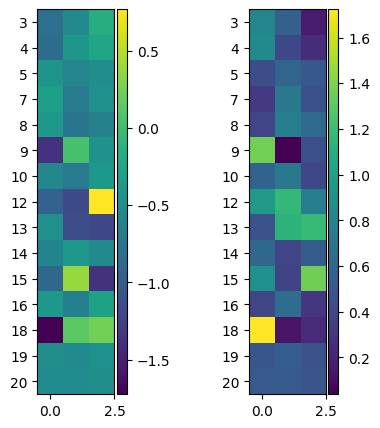

In [1647]:
spatial_weights = vaearhmm.vae.decoder.spatial_filter.weight.data.cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(5, 5))
img0 = ax[0].imshow(spatial_weights)
ax[0].set_yticks(np.arange(spatial_weights.shape[0]))
ax[0].set_yticklabels(list(np.where(~bad_channels)[0]+1))
cax0 = fig.add_axes([ax[0].get_position().x1+0.005, ax[0].get_position().y0, 0.02, ax[0].get_position().height]);
plt.colorbar(img0, cax=cax0)
img1 = ax[1].imshow(np.abs(spatial_weights))
ax[1].set_yticks(np.arange(spatial_weights.shape[0]))
ax[1].set_yticklabels(list(np.where(~bad_channels)[0]+1))
cax1 = fig.add_axes([ax[1].get_position().x1+0.005, ax[1].get_position().y0, 0.02, ax[1].get_position().height]);
plt.colorbar(img1, cax=cax1)
plt.show()

# Classic

In [1943]:
class Config:
    def __init__(self):
        pass
        
config = Config()
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.random_seed = 42

config.n_states = 2
config.n_features = 3
config.n_channels = 15


# hmm params
config.init_state_type = 'first'
config.transition_matrix_type = 'random'
config.transition_type = 'full'
config.diagonal_coef = 0
config.first_coef = 10
config.ergodicity_coef = 0
config.temperature = 1

# ar params
config.ar_order = 0

# vae params
config.log_transform = False
config.fsds = 1024
config.fsamp = 16
config.ds_coef = int(config.fsds/config.fsamp)
config.ma_order_encoder = 0
config.ma_order_decoder = 0
config.use_ma_bias = True
config.ma_bias_common = True
config.use_temporal_smoother = False
config.temporal_smoother_kernel = 75
config.sigma2y = 1
config.use_cov_scaler = True
config.cov_propagation = False

config.pretain_epoch = 5000
config.batch_size = 100
config.seq_length = 50
config.n_iterations = 50
config.n_epochs = 0
config.lr = 3e-4
config.weight_decay = 1e-4

In [1944]:
experiment = None
experiment = Experiment(
    api_key="h1D6l9T1S26xlDYKakWxGBudo",
    project_name="vae",
    workspace="amvosk",
    auto_output_logging=False,
)
experiment.log_code()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch, sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/user/common/amvosk/Projects/Speech Mapping Advanced' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/amvosk/vae/300983cecbda4452a309fd8e6849223c

COMET WARNING: unable to find caller source code in a jupyter notebook; ignoring


In [1945]:
vaearhmm = VAEARHMM(
    config,
    experiment,
).to(config.device)
y = torch.tensor(ecogf, dtype=torch.float32).to(config.device)

In [1946]:
# vaearhmm.hmm.to('cuda')

In [1947]:
print(vaearhmm.hmm.init_state)
print(vaearhmm.hmm.transition_matrix)
print(vaearhmm.ar._get_mean())
print(vaearhmm.ar._get_cov())
print(vaearhmm.ar._get_ar_coef())
if config.use_ma_bias:
    print(vaearhmm.vae.ma_bias)
if config.use_cov_scaler:
    print(vaearhmm.vae.cov_scaler)

tensor([1.0000e+00, 1.0000e-07], device='cuda:0')
tensor([[0.9224, 0.0776],
        [0.2853, 0.7147]], device='cuda:0')
tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')
tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]], device='cuda:0')
tensor([], device='cuda:0', size=(2, 0, 3, 3))
Parameter containing:
tensor([0., 0., 0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)


In [1948]:
# vaearhmm.fit(y, config)
vaearhmm.fit_simple(y, config)
if experiment is not None:
    experiment.end()

100%|██████████| 50/50 [01:28<00:00,  1.77s/it]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/amvosk/vae/300983cecbda4452a309fd8e6849223c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     dkl [500]      : (2.34604549407959, 4.628284931182861)
COMET INFO:     loss [500]     : (46.78049850463867, 119.1422119140625)
COMET INFO:     prob_loss [50] : (4826.923828125, 10638.2724609375)
COMET INFO:     rec [500]      : (44.42978286743164, 114.51392364501953)
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1

In [1949]:
if experiment is not None:
    experiment.end()

In [1950]:
y_minibatch, y_mean_tilde, y_cov_tilde, x_mean, x_cov, path = vaearhmm.prefict(y)

In [1951]:
# y_cov_tilde[...,1000]

In [1952]:
# x_cov[...,100]

In [1953]:
print(vaearhmm.hmm.init_state)
print(vaearhmm.hmm.transition_matrix)
print(vaearhmm.ar._get_mean())
print(vaearhmm.ar._get_cov())
print(vaearhmm.ar._get_ar_coef())
if config.use_ma_bias:
    print(vaearhmm.vae.ma_bias)
if config.use_cov_scaler:
    print(vaearhmm.vae.cov_scaler)

tensor([1., 0.], device='cuda:0')
tensor([[0.9395, 0.0605],
        [0.2060, 0.7940]], device='cuda:0')
tensor([[ 0.0012, -0.0297, -0.0151],
        [ 0.3106,  0.6576,  0.3372]], device='cuda:0')
tensor([[[ 0.1212,  0.0098,  0.0086],
         [ 0.0098,  0.1144,  0.0020],
         [ 0.0086,  0.0020,  0.0835]],

        [[ 0.2603, -0.0710,  0.0415],
         [-0.0710,  0.4971,  0.0246],
         [ 0.0415,  0.0246,  0.2166]]], device='cuda:0')
tensor([], device='cuda:0', size=(2, 0, 3, 3))
Parameter containing:
tensor([-1.1206, -1.1169, -0.9466], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.5702], device='cuda:0', requires_grad=True)


In [1954]:
total_memory = psutil.virtual_memory().total
available_memory = psutil.virtual_memory().available
print(f"The available RAM memory is {available_memory / (1024**3):.2f} GB out of {total_memory / (1024**3):.2f} GB")

The available RAM memory is 54.08 GB out of 125.68 GB


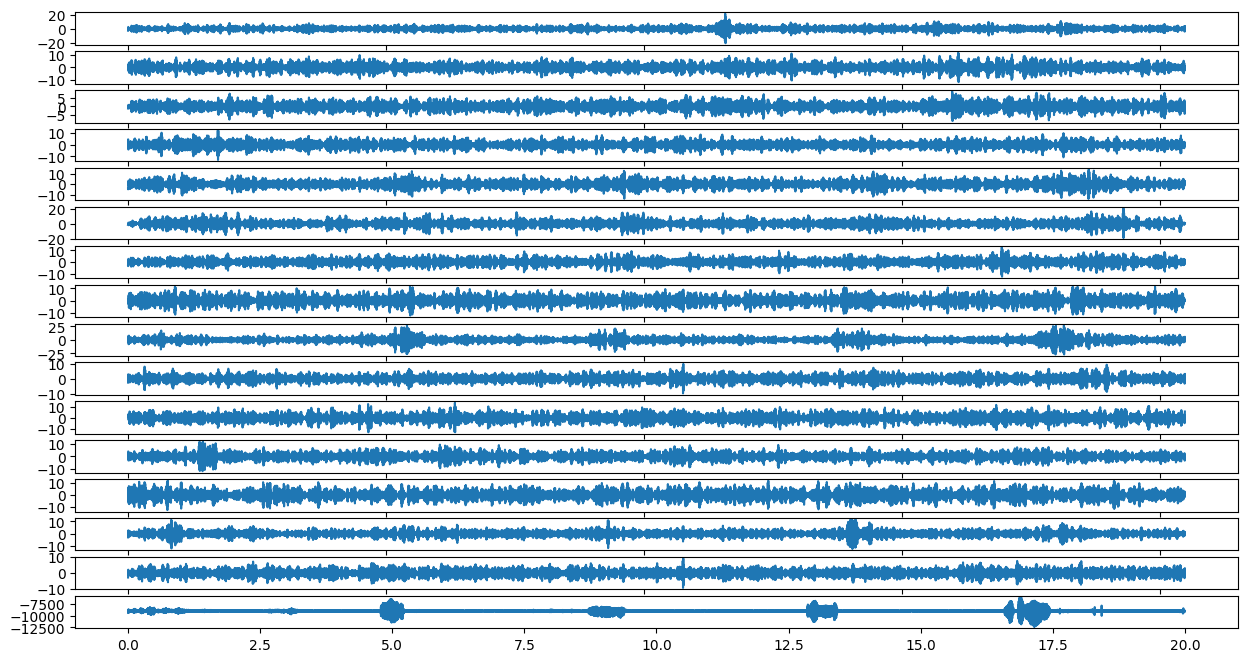

In [1955]:
N = ecogf.shape[0]
a = stimulus[0]
s, t = a, a + 20*fsds
s_, t_ = a_, a_ + 20*fs

fig, ax = plt.subplots(N+1, 1, figsize=(15, 0.5*(N+1)))
for i in range(N):
    ax[i].plot(ecogf[i, s:t])
ax[N].plot(np.arange(sound[s_:t_].shape[0])/fs, sound[s_:t_])
plt.show()

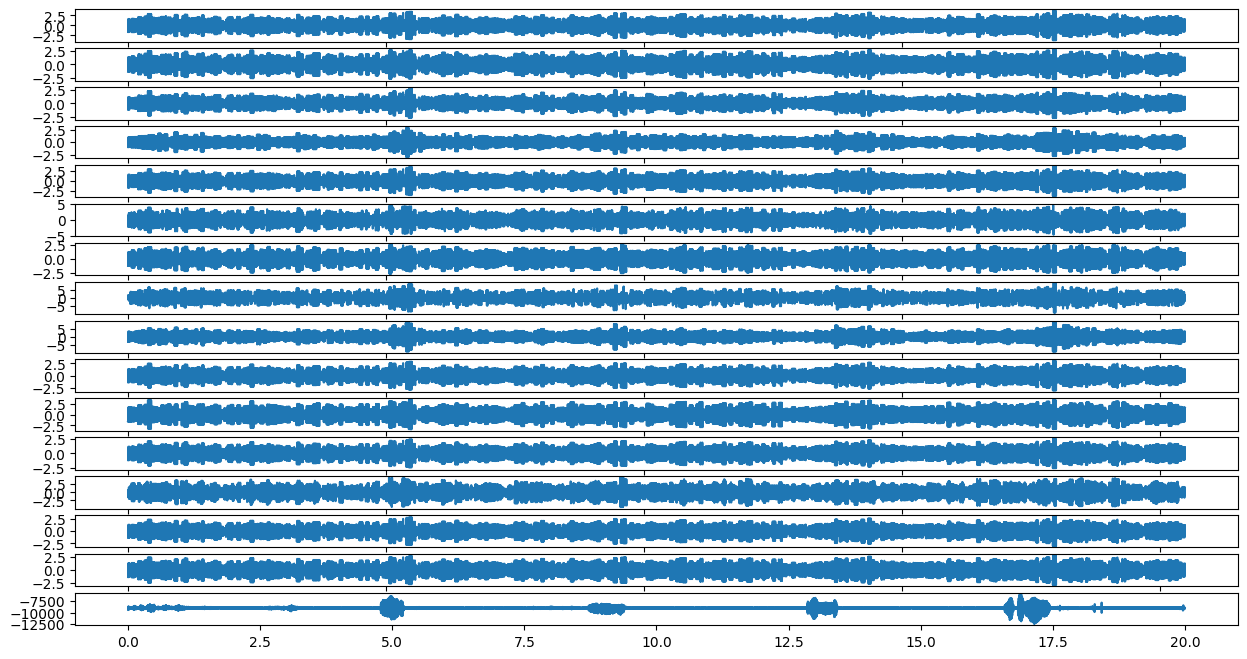

In [1956]:
y_hat = y_mean_tilde.detach().cpu().numpy()

N = y_hat.shape[0]
s, t = a, a + 20*fsds
s_, t_ = a_, a_ + 20*fs

fig, ax = plt.subplots(N+1, 1, figsize=(15, 0.5*(N+1)))
for i in range(N):
    ax[i].plot(y_hat[i, s:t])
ax[N].plot(np.arange(sound[s_:t_].shape[0])/fs, sound[s_:t_])
plt.show()

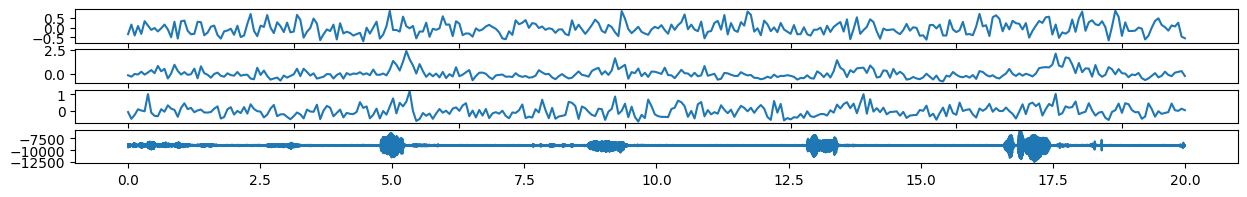

In [1957]:
x_hat = x_mean.detach().cpu().numpy()

N = x_hat.shape[0]
s, t = a, a + 20*config.fsamp
s_, t_ = a_, a_ + 20*fs

fig, ax = plt.subplots(N+1, 1, figsize=(15, 0.5*(N+1)))
for i in range(N):
    ax[i].plot(x_hat[i, s:t])
ax[N].plot(np.arange(sound[s_:t_].shape[0])/fs, sound[s_:t_])
plt.show()

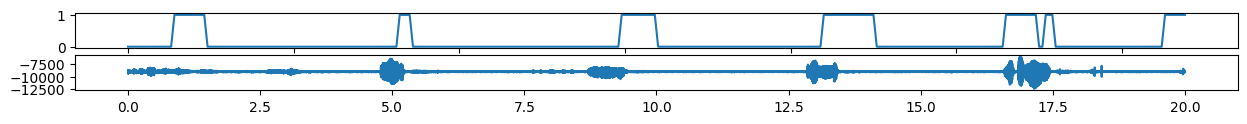

In [1958]:
z_hat = path.detach().cpu().numpy()

s, t = b, b + 20*config.fsamp
s_, t_ = a_, a_ + 20*fs

fig, ax = plt.subplots(2, 1, figsize=(15, 1))
ax[0].plot(z_hat[s:t])
ax[1].plot(np.arange(sound[s_:t_].shape[0])/fs, sound[s_:t_])
plt.show()

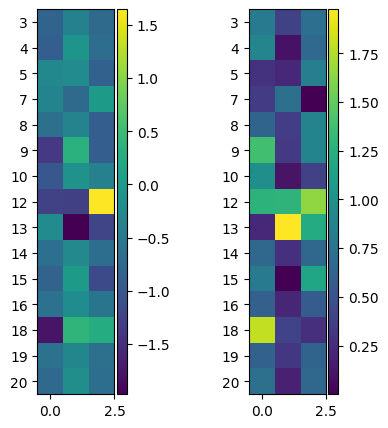

In [1959]:
spatial_weights = vaearhmm.vae.decoder.spatial_filter.weight.data.cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(5, 5))
img0 = ax[0].imshow(spatial_weights)
ax[0].set_yticks(np.arange(spatial_weights.shape[0]))
ax[0].set_yticklabels(list(np.where(~bad_channels)[0]+1))
cax0 = fig.add_axes([ax[0].get_position().x1+0.005, ax[0].get_position().y0, 0.02, ax[0].get_position().height]);
plt.colorbar(img0, cax=cax0)
img1 = ax[1].imshow(np.abs(spatial_weights))
ax[1].set_yticks(np.arange(spatial_weights.shape[0]))
ax[1].set_yticklabels(list(np.where(~bad_channels)[0]+1))
cax1 = fig.add_axes([ax[1].get_position().x1+0.005, ax[1].get_position().y0, 0.02, ax[1].get_position().height]);
plt.colorbar(img1, cax=cax1)
plt.show()

In [1844]:
from hmmlearn import hmm

hmmmodel = hmm.GaussianHMM(n_components=config.n_states, tol=5, verbose=False, n_iter=100)
hmmmodel.fit(x_hat.T)

/opt/conda/envs/megasr/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


GaussianHMM(n_components=2, n_iter=100, tol=5)

In [1845]:
# print(vaearhmm.ar._get_mean())
# print(hmmmodel.means_)

In [1846]:
# print(vaearhmm.ar._get_cov())
# print(hmmmodel.covars_)

In [1847]:
z = hmmmodel.predict(x_hat.T)

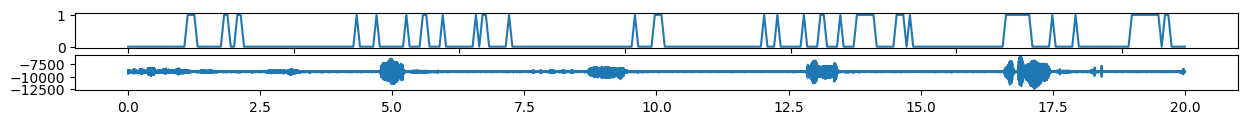

In [1848]:
s, t = b, b + 20*config.fsamp
s_, t_ = a_, a_ + 20*fs

fig, ax = plt.subplots(2, 1, figsize=(15, 1))
ax[0].plot(z[s:t])
ax[1].plot(np.arange(sound[s_:t_].shape[0])/fs, sound[s_:t_])
plt.show()

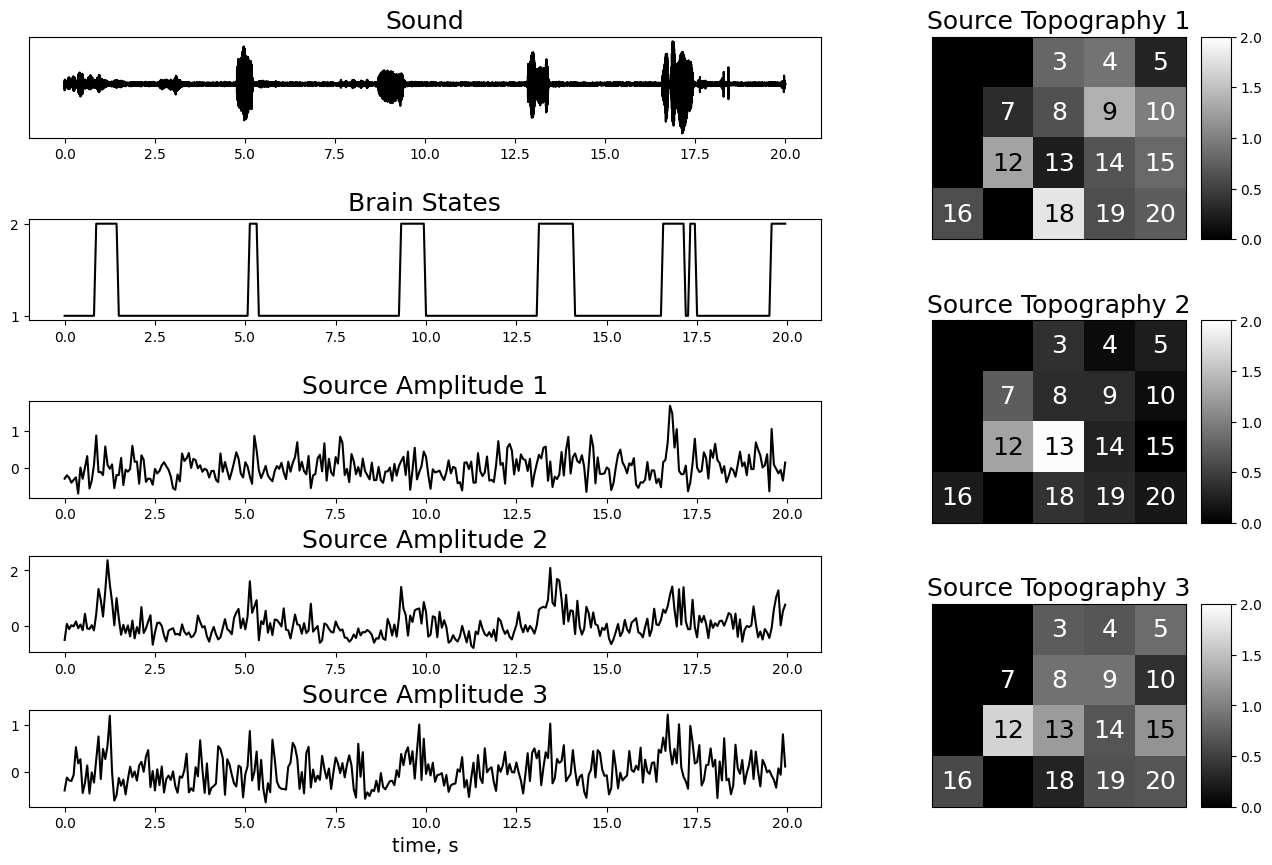

In [1963]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create sample data
cmap = plt.cm.gray
cmap.set_bad(color='black')

fig = plt.figure(figsize=(15, 10))
outer_gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[3, 1])

# Create left subplot (empty for now)
left_gs = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer_gs[0, 0], hspace=0.4, height_ratios=[1, 1, 4])

ax = fig.add_subplot(left_gs[0])
ax.plot(np.arange(sound[s_:t_].shape[0])/fs, sound[s_:t_], color='black')
ax.set_yticks([])
ax.set_title('Sound', fontsize=18)

ax = fig.add_subplot(left_gs[1])
ax.plot(np.arange(z_hat[s:t].shape[0]) / config.fsamp, z_hat[s:t]+1, color='black')
ax.set_yticks([1, 2])
# ax.set_ylabel(f'state', fontsize=14)
ax.set_title('Brain States', fontsize=18)

inner_lower_gs = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0.6, subplot_spec=left_gs[2])
for i in range(3):
    ax = fig.add_subplot(inner_lower_gs[i])
    ax.plot(np.arange(x_hat[i, s:t].shape[0]) / config.fsamp, x_hat[i, s:t], color='black')
    # ax.set_yticks([])
    # if i == 1:
        # ax.set_ylabel(f'source amplitude', fontsize=14)
    # ax.set_xlabel(f'Group {i+3}')
    ax.set_title(f'Source Amplitude {i + 1}', fontsize=18)
ax.set_xlabel(f'time, s', fontsize=14)

# Create right subplot using GridSpec
right_gs = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer_gs[0, 1], hspace=0.4)

for k in range(3):  # Assuming you have 3 features
    data = np.zeros(20)
    data[~bad_channels] = np.abs(spatial_weights[:, k])
    mask = bad_channels

    # Reshape the data and mask into 4x5 grids
    data_grid = data.reshape(4, 5)
    mask_grid = mask.reshape(4, 5)

    # Set masked elements to a special value (e.g., -1)
    masked_data_grid = np.where(mask_grid, -1, data_grid)

    # Create the subplot
    ax = fig.add_subplot(right_gs[k])

    # Create the plot with a colormap and show masked values in black
    im = ax.imshow(masked_data_grid, cmap=cmap, vmin=0, vmax=2)

    # Add the index values as text to each cell
    for i in range(4):
        for j in range(5):
            if not bad_channels[5 * i + j]:
                color = 'w' if data[5 * i + j] < 1 else 'black'
                ax.text(j, i, f'{5 * i + j + 1}', ha='center', fontsize=18, va='center', color=color)

    # Remove ticks, x, and y labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    cbar = fig.colorbar(im, cax=cax)
    ax.set_title(f'Source Topography {k + 1}', fontsize=18)

# Save and display the figure
plt.savefig('results_main_update.png', dpi=600)
plt.show()

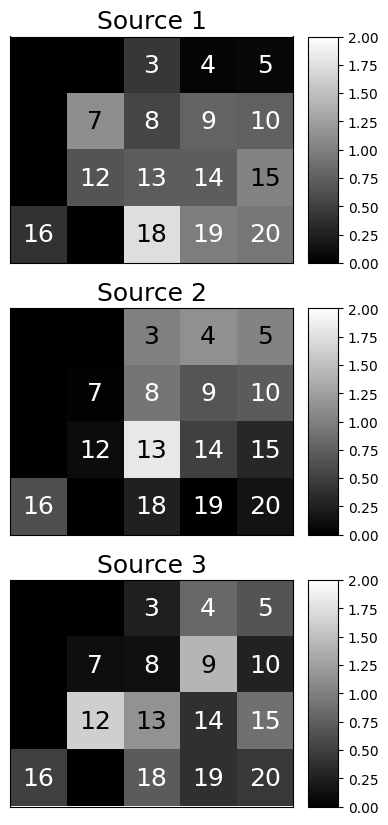

In [1504]:
import numpy as np
import matplotlib.pyplot as plt

# Create sample data
cmap = plt.cm.gray
cmap.set_bad(color='black')

fig, ax = plt.subplots(3, 1, figsize=(15, 10))

for k in range(config.n_features):
    data = np.zeros(20)
    data[~bad_channels] = np.abs(spatial_weights[:,k])
    mask = bad_channels

    # Reshape the data and mask into 4x5 grids
    data_grid = data.reshape(4, 5)
    mask_grid = mask.reshape(4, 5)

    # Set masked elements to a special value (e.g., -1)
    masked_data_grid = np.where(mask_grid, -1, data_grid)

    # Create the figure and axis


    # Create the plot with a colormap and show masked values in black
    im = ax[k].imshow(masked_data_grid, cmap=cmap, vmin=0, vmax=2)

    # Add the index values as text to each cell
    for i in range(4):
        for j in range(5):
            if not bad_channels[5*i+j]:
                color = 'w' if data[5*i+j] < 1 else 'black'
                ax[k].text(j, i, f'{5*i+j+1}', ha='center', fontsize=18, va='center', color=color)

    # Remove ticks, x, and y labels
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ax[k].set_xticklabels([])
    ax[k].set_yticklabels([])
    cax = fig.add_axes([ax[k].get_position().x1 + 0.01, ax[k].get_position().y0, 0.02, ax[k].get_position().height])
    cbar = fig.colorbar(im, cax=cax)
    ax[k].set_title(f'Source {k+1}', fontsize=18)

# Save and display the figure
plt.savefig('masked_grid_plot_no_ticks.png', dpi=300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

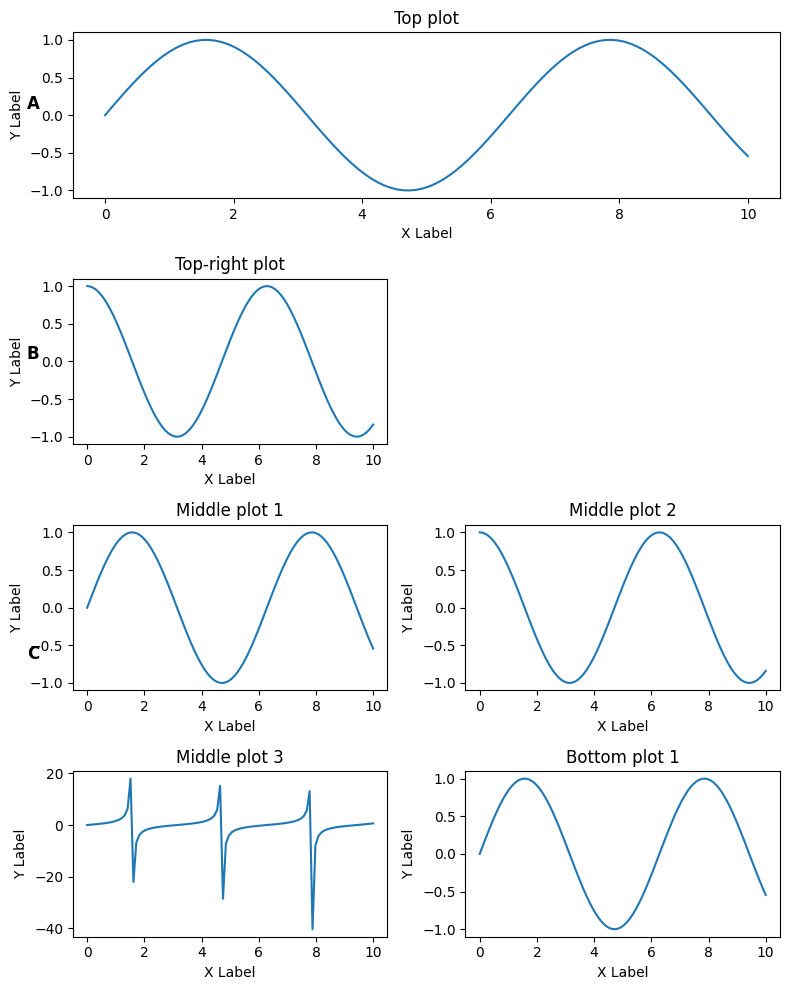

In [1436]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
t = np.linspace(0, 10, 100)
y1 = np.sin(t)
y2 = np.cos(t)
y3 = np.tan(t)

# Create the figure and axes
fig = plt.figure(figsize=(8, 10))

# Top plot (1 time-series)
ax1 = fig.add_subplot(4, 2, (1, 2))
ax1.plot(t, y1)
ax1.set_title('Top plot')
ax1.set_ylabel('Y Label')
ax1.set_xlabel('X Label')

# Top-right plot (1 time-series)
ax2 = fig.add_subplot(4, 2, 3)
ax2.plot(t, y2)
ax2.set_title('Top-right plot')
ax2.set_ylabel('Y Label')
ax2.set_xlabel('X Label')

# Middle plots (3 time-series)
ax3 = fig.add_subplot(4, 2, 5)
ax3.plot(t, y1)
ax3.set_title('Middle plot 1')
ax3.set_ylabel('Y Label')
ax3.set_xlabel('X Label')

ax4 = fig.add_subplot(4, 2, 6)
ax4.plot(t, y2)
ax4.set_title('Middle plot 2')
ax4.set_ylabel('Y Label')
ax4.set_xlabel('X Label')

ax5 = fig.add_subplot(4, 2, 7)
ax5.plot(t, y3)
ax5.set_title('Middle plot 3')
ax5.set_ylabel('Y Label')
ax5.set_xlabel('X Label')

# Bottom plots (3 time-series)
ax6 = fig.add_subplot(4, 2, 8)
ax6.plot(t, y1)
ax6.set_title('Bottom plot 1')
ax6.set_ylabel('Y Label')
ax6.set_xlabel('X Label')

fig.tight_layout()

# Add labels for each subplot group
fig.text(0.04, 0.9, 'A', fontsize=12, fontweight='bold', va='top')
fig.text(0.04, 0.65, 'B', fontsize=12, fontweight='bold', va='top')
fig.text(0.04, 0.35, 'C', fontsize=12, fontweight='bold', va='top')

# Save and display the figure
plt.savefig('group_plot.png', dpi=300)
plt.show()